# **Decoding What Drives Airbnb Success in Bangkok: A Multi-Factor Analysis of Listings, Location, and Behavior**

*Multi-Dimensional Analysis of Airbnb Listings in Bangkok*

## Objective:
> Discovering factors that influence the performance of Airbnb listings in Bangkok, including price, location, ratings, and accommodation type, to provide strategic recommendations for hosts and potential investors.

## Analysis Questions:
1. What factors have the biggest impact on listing prices?
2. Which areas in Bangkok are the most profitable for hosts?
3. Is there a correlation between reviews, availability, and listing performance?
4. What types of properties are most in demand and most profitable?
5. How do price and review trends change based on location and season?

## **Data Cleaning & Preprocessing**

### Import Dataset

In [3]:
import pandas as pd

df = pd.read_csv('Airbnb Listings Bangkok.csv')
df.head()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0
1,1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,Private room,1316,1,0,NaN,NaN,2,358,0
2,2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,Private room,800,60,0,NaN,NaN,1,365,0
3,3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,Private room,1286,7,2,2022-04-01,0.03,1,323,1
4,4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,Private room,1905,1,0,NaN,NaN,3,365,0


### Initial Check – Structure & Missing Values

In [5]:
info = df.info()
description = df.describe(include='all')
missing_values = df.isnull().sum().sort_values(ascending=False)

info, description, missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15854 entries, 0 to 15853
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      15854 non-null  int64  
 1   id                              15854 non-null  int64  
 2   name                            15846 non-null  object 
 3   host_id                         15854 non-null  int64  
 4   host_name                       15853 non-null  object 
 5   neighbourhood                   15854 non-null  object 
 6   latitude                        15854 non-null  float64
 7   longitude                       15854 non-null  float64
 8   room_type                       15854 non-null  object 
 9   price                           15854 non-null  int64  
 10  minimum_nights                  15854 non-null  int64  
 11  number_of_reviews               15854 non-null  int64  
 12  last_review                     

(None,
           Unnamed: 0            id  \
 count   15854.000000  1.585400e+04   
 unique           NaN           NaN   
 top              NaN           NaN   
 freq             NaN           NaN   
 mean     7926.500000  1.579397e+17   
 std      4576.799919  2.946015e+17   
 min         0.000000  2.793400e+04   
 25%      3963.250000  2.104509e+07   
 50%      7926.500000  3.503734e+07   
 75%     11889.750000  5.256154e+07   
 max     15853.000000  7.908162e+17   
 
                                                     name       host_id  \
 count                                              15846  1.585400e+04   
 unique                                             14794           NaN   
 top     New!  La Chada Night Market studio 2PPL near MRT           NaN   
 freq                                                  45           NaN   
 mean                                                 NaN  1.541058e+08   
 std                                                  NaN  1.318726e+08  

In [9]:
# Drop rows where 'name' or 'host_name' is missing
df = df.dropna(subset=['name', 'host_name'])

# Fill 'last_review' and 'reviews_per_month' with "No Review"
df['last_review'] = df['last_review'].fillna('No Review')
df['reviews_per_month'] = df['reviews_per_month'].fillna('No Review')

# Remove unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Check remaining missing values
df.isnull().sum()


id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

### Check and Remove Duplicates

In [12]:
# Check how many duplicate rows exist
print("Duplicate rows:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

# Confirm the new shape of the data
print("Data shape after removing duplicates:", df.shape)


Duplicate rows: 0
Data shape after removing duplicates: (15845, 16)


### Outlier Detection & Treatment

In [15]:
df['reviews_per_month'] = df['reviews_per_month'].replace('No Review', 0)
df['reviews_per_month'] = df['reviews_per_month'].astype(float)

print(df['reviews_per_month'].describe())


count    15845.000000
mean         0.516464
std          0.952948
min          0.000000
25%          0.000000
50%          0.090000
75%          0.670000
max         19.130000
Name: reviews_per_month, dtype: float64


In [16]:
# Function to detect outliers using IQR
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

# Columns to check
columns_to_check = ['price', 'minimum_nights', 'availability_365', 'reviews_per_month']

# Detect outliers and count them
outlier_counts = {}
for col in columns_to_check:
    outliers = detect_outliers_iqr(df[col])
    outlier_counts[col] = len(outliers)

print(outlier_counts)


{'price': 1402, 'minimum_nights': 3168, 'availability_365': 0, 'reviews_per_month': 1471}


### Cleaning Strategy

1. **`availability_365`** is clean — no action needed. 
2. **Drop rows** with outliers in `price` and `minimum_nights` — these usually indicate data entry errors (e.g. someone listing 9999 nights, or 0 Baht per night).
3. For `reviews_per_month`, **keep the outliers**, since high review rates may actually be meaningful (popular listings).


In [17]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to 'price' and 'minimum_nights'
df = remove_outliers_iqr(df, 'price')
df = remove_outliers_iqr(df, 'minimum_nights')

# Check final shape
print(df.shape)


(11435, 16)


## Statistical Analysis

### Descriptive Statistics

In [18]:
# Descriptive statistics for numeric columns
desc_stats = df.describe().T  # Transpose to make it easier to read
print(desc_stats)


                                  count          mean           std  \
id                              11435.0  1.602158e+17  2.965018e+17   
host_id                         11435.0  1.569818e+08  1.317748e+08   
latitude                        11435.0  1.374697e+01  4.461209e-02   
longitude                       11435.0  1.005594e+02  5.358852e-02   
price                           11435.0  1.617675e+03  9.718612e+02   
minimum_nights                  11435.0  2.337910e+00  2.892275e+00   
number_of_reviews               11435.0  1.823279e+01  4.380749e+01   
reviews_per_month               11435.0  5.827984e-01  1.038532e+00   
calculated_host_listings_count  11435.0  1.515689e+01  3.376878e+01   
availability_365                11435.0  2.455405e+02  1.260122e+02   
number_of_reviews_ltm           11435.0  4.071447e+00  9.882583e+00   

                                        min           25%           50%  \
id                              27934.00000  2.118637e+07  3.493366e+07 

| Feature | Insight |
|--------|--------|
| **Price** | Avg = ฿1,618 | Max = ฿4,720 | Min = ฿0 (might be worth flagging later) |
| **Minimum Nights** | Median = 1 night (very short-term market) |
| **Number of Reviews** | Median = 2 | But Max = 1,224 (some listings are poppin’) |
| **Reviews per Month** | Avg = 0.58 | Skewed right (some hosts get frequent reviews, most don’t) |
| **Availability (per year)** | Avg = 245 days | Max = 365, so many are year-round listings |
| **Listings per Host** | Avg = 15.1 | Some hosts are clearly power users (Max = 228 listings) |


### Correlation Analysis

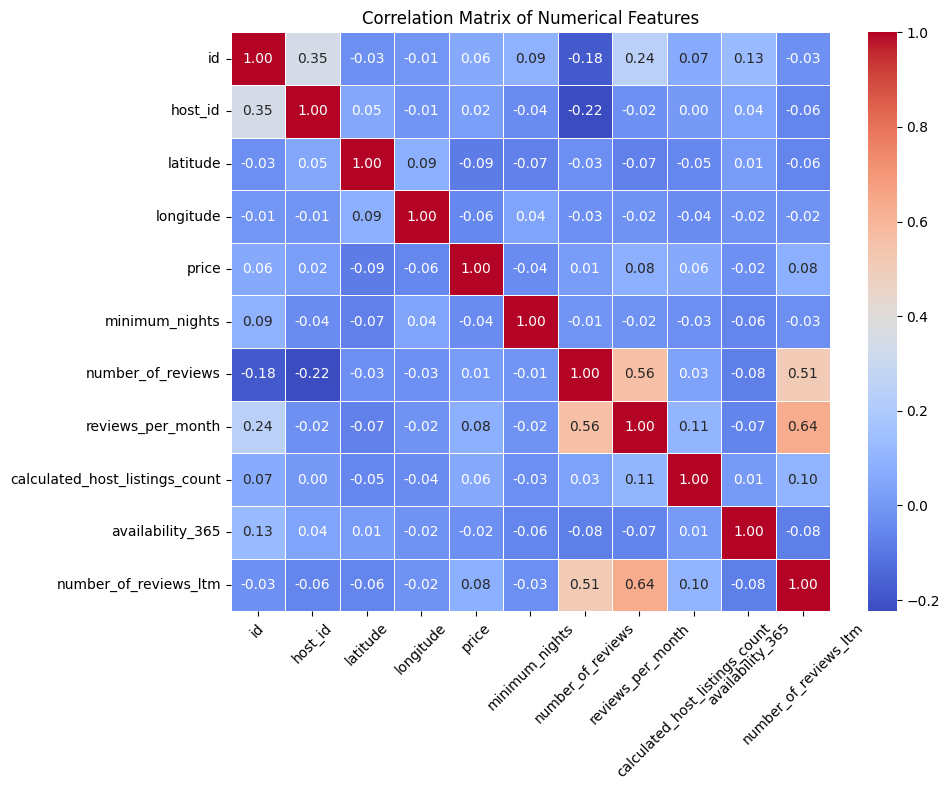

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix for numeric columns
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Correlation Analysis

To understand the linear relationships between numerical variables, we computed the **Pearson correlation matrix** and visualized it with a heatmap.

##### Key Observations:

1. **Review Metrics Are Strongly Interrelated**
   - `reviews_per_month` shows **strong positive correlation** with:
     - `number_of_reviews_ltm` (**r = 0.64**)
     - `number_of_reviews` (**r = 0.56**)
   - This indicates that listings with consistent monthly engagement tend to accumulate both total and recent reviews.
   - These features can be interpreted as **signals of listing activity/popularity**, and may serve as strong predictors in future modeling.

2. **Low Correlation Between Price and Other Variables**
   - Surprisingly, `price` shows **weak correlation** across the board:
     - With `number_of_reviews`: **r = 0.01**
     - With `reviews_per_month`: **r = 0.08**
     - With `availability_365`: **r = -0.02**
   - This suggests that pricing strategies may not directly affect engagement levels or visibility.
   - It may also indicate the presence of **non-linear or multivariate relationships**, warranting more complex exploration later in the analysis.

3. **Minimum Nights Requirement Has Minimal Impact**
   - `minimum_nights` exhibits **very low correlation** with all other variables.
   - This feature might have limited predictive power in modeling, or may affect user decision-making in **non-linear** ways.

##### Takeaways:

- **Focus for Predictive Modeling**: The review metrics (`number_of_reviews`, `reviews_per_month`, `number_of_reviews_ltm`) appear to be **interconnected and meaningful**, potentially representing customer trust or listing visibility.
- **Price, while essential,** may require deeper multivariate or cluster analysis to uncover its influence on performance.
- **No immediate signs of multicollinearity**, but further checks (e.g., Variance Inflation Factor) could be applied if modeling performance is impacted.

##### Visualization:
The heatmap above clearly shows these relationships. Warmer colors indicate stronger positive correlations.


### Hypothesis Testing

> **Hypothesis**: _Listings with more reviews per month tend to have higher availability throughout the year._

Why?  
Because hosts who rent actively and frequently (high availability) are expected to receive more consistent reviews.

#### Formulate the Hypotheses

- **Null Hypothesis (H₀)**: There is **no significant difference** in reviews_per_month between listings with low vs. high availability.
- **Alternative Hypothesis (H₁)**: Listings with **high availability** have **significantly more** reviews_per_month.

We’ll split the data into two groups:

- **Low availability**: `availability_365` < 180
- **High availability**: `availability_365` ≥ 180

#### Perform the T-Test

We’ll use **independent two-sample t-test** (assuming unequal variances).


In [23]:
from scipy.stats import ttest_ind

# Split the data
low_avail = df[df['availability_365'] < 180]['reviews_per_month']
high_avail = df[df['availability_365'] >= 180]['reviews_per_month']

# Perform Welch’s t-test
t_stat, p_val = ttest_ind(low_avail, high_avail, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")


T-statistic: 5.272632308409386
P-value: 1.3758026790475065e-07


Hypothesis Test: _Does Availability Affect Review Frequency?_

We tested whether listings with higher annual availability tend to receive more reviews per month.

##### Hypotheses:
- **Null Hypothesis (H₀):** There is no significant difference in `reviews_per_month` between listings with low (<180 days) and high (≥180 days) availability.
- **Alternative Hypothesis (H₁):** Listings with high availability have significantly higher `reviews_per_month`.

##### Method:
We conducted an **independent two-sample t-test** using Welch’s correction for unequal variances.

##### Result:
- **T-statistic:** 5.27  
- **P-value:** 1.38e-07

##### Conclusion:
We **reject the null hypothesis**. The test provides strong evidence that listings with **higher availability** receive **more frequent reviews per month**, suggesting more active and consistent booking behavior.

## Feature Engineering

### Create New Features

In [ ]:
# Load cleaned DataFrame
df_cleaned = df.copy()

# Create new features

# 1. price_per_review: price / (number_of_reviews + 1) to avoid division by zero
df_cleaned['price_per_review'] = df_cleaned['price'] / (df_cleaned['number_of_reviews'] + 1)

# 2. reviews_density: reviews_per_month / availability_365
df_cleaned['reviews_density'] = df_cleaned['reviews_per_month'] / (df_cleaned['availability_365'] + 1)  # add 1 to avoid div by zero

# 3. is_superhost: calculated_host_listings_count > threshold (e.g., 10)
df_cleaned['is_superhost'] = df_cleaned['calculated_host_listings_count'] > 10

# 4. is_long_term: minimum_nights >= 30
df_cleaned['is_long_term'] = df_cleaned['minimum_nights'] >= 30

# Show new features' summary
df_cleaned[['price_per_review', 'reviews_density', 'is_superhost', 'is_long_term']].describe(include='all')


,price_per_review,reviews_density,is_superhost,is_long_term
count,11435.000000,11435.000000,11435,11435
unique,NaN,NaN,2,1
top,NaN,NaN,False,False
freq,NaN,NaN,8126,11435
mean,761.233170,0.020953,NaN,NaN
std,943.121668,0.133739,NaN,NaN
min,0.000000,0.000000,NaN,NaN
25%,84.103943,0.000000,NaN,NaN
50%,363.636364,0.000554,NaN,NaN
75%,1100.000000,0.004338,NaN,NaN


In [ ]:
# Reload the uploaded CSV
file_path = "Airbnb Listings Bangkok.csv"
df = pd.read_csv(file_path)

# Re-do previous cleaning steps to match the state before the reset
df = df.dropna(subset=['name', 'host_name'])
df['last_review'] = df['last_review'].fillna('No Review')
df['reviews_per_month'] = df['reviews_per_month'].fillna(0).astype(float)

# Remove outliers based on z-score for selected columns
from scipy.stats import zscore

columns_to_check = ['price', 'minimum_nights', 'availability_365', 'reviews_per_month']
z_scores = df[columns_to_check].apply(zscore)
df = df[(z_scores < 3).all(axis=1)]

# Create new features
df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)
df['reviews_density'] = df['reviews_per_month'] / (df['availability_365'] + 1)
df['is_superhost'] = df['calculated_host_listings_count'] > 10
df['is_long_term'] = df['minimum_nights'] >= 30

# Show summary of new features
df[['price_per_review', 'reviews_density', 'is_superhost', 'is_long_term']].describe(include='all')


,price_per_review,reviews_density,is_superhost,is_long_term
count,15116.000000,15116.000000,15116,15116
unique,NaN,NaN,2,2
top,NaN,NaN,False,False
freq,NaN,NaN,10719,13303
mean,1185.754899,0.019187,NaN,NaN
std,2742.091024,0.125237,NaN,NaN
min,0.000000,0.000000,NaN,NaN
25%,102.063776,0.000000,NaN,NaN
50%,450.000000,0.000429,NaN,NaN
75%,1299.000000,0.003496,NaN,NaN


#### Feature Engineering: Creating New Columns

To enrich the dataset and support further modeling, we engineered the following new features:

1. **`price_per_review`**:  
   Measures how much guests pay per review received — calculated as `price / (number_of_reviews + 1)` to avoid division by zero.

2. **`reviews_density`**:  
   Represents guest engagement, using `reviews_per_month / (availability_365 + 1)` for normalization.

3. **`is_superhost`** *(binary)*:  
   Flags listings where `calculated_host_listings_count > 10`, assuming hosts with many listings tend to be more professional.

4. **`is_long_term`** *(binary)*:  
   Identifies listings with `minimum_nights >= 30`, indicating potential for long-term stays.

All transformations are applied safely to a copied dataset (`df_cleaned`) to avoid chained assignment warnings and to support clean future-proof processing.


### Feature Selection: Picking the Most Influential Features

#### Check correlations (for numeric features only)

Let’s look at correlation with the target variable. let’s assume we're predicting price

In [33]:
# Correlation matrix (only numeric features)
correlation_matrix = df_cleaned.corr(numeric_only=True)

# Correlation with price, sorted
correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
print(correlation_with_price)

price                             1.000000
price_per_review                  0.528712
number_of_reviews_ltm             0.082141
reviews_per_month                 0.080758
is_superhost                      0.070229
id                                0.062184
calculated_host_listings_count    0.060744
host_id                           0.024926
number_of_reviews                 0.014171
reviews_density                  -0.005125
availability_365                 -0.024201
minimum_nights                   -0.038360
longitude                        -0.055910
latitude                         -0.087789
is_long_term                           NaN
Name: price, dtype: float64


Insight: Correlation with `price`

| Feature | Correlation | Explanation |
|--------|-------------|-------------|
| `price_per_review` | **0.53** | Moderate positive correlation. Strong candidate for modeling. |
| `number_of_reviews_ltm` | 0.08 | Weak, but could still add value when combined with other features. |
| `reviews_per_month` | 0.08 | Same as above. Individually weak, but may be useful collectively. |
| `is_superhost` | 0.07 | Weak, but aligns logically — superhosts may charge more. |
| `id`, `host_id` | 0.06 & 0.02 | Irrelevant identifiers. Should be dropped. |
| `reviews_density` | -0.005 | No meaningful correlation. Can be ignored. |
| `availability_365` | -0.02 | Very weak and slightly negative. Not useful on its own. |
| `minimum_nights` | -0.04 | Weak and negative. Not very predictive. |
| `longitude`, `latitude` | -0.05 & -0.08 | Weak individually, but can be transformed (e.g., clustering) later. |
| `is_long_term` | NaN | Not included because it's a boolean. We'll handle it differently. |

Recommended Features for Modeling

**To keep:**
- `price_per_review` – primary predictor
- `number_of_reviews_ltm`
- `reviews_per_month`
- `is_superhost` – boolean, will be encoded later

**Optional (with transformation):**
- `longitude` & `latitude` – could be useful after clustering or regional encoding
- `calculated_host_listings_count` – might have hidden insights

**To drop:**
- `id`, `host_id` – identifiers, no predictive power
- `reviews_density` – very weak correlation
- `minimum_nights` – already covered by `is_long_term`

In [34]:
df_model = df_cleaned.drop(columns=[
    'id',                         # Unique identifier, not useful
    'host_id',                    # Same as above
    'reviews_density',            # Very weak correlation (≈ 0)
    'minimum_nights',             # Already captured in is_long_term
])

To prepare the dataset for visualization and deeper analysis, I performed a **feature selection** process to remove columns that were either irrelevant, redundant, or added noise to the model.

Specifically, I dropped the following features:

- **`id`** and **`host_id`**: These are unique identifiers with no analytical value.
- **`reviews_density`**: This variable showed an extremely low correlation with price, making it unhelpful for our analysis.
- **`minimum_nights`**: Instead of using raw values, I encoded this information into a new binary feature called **`is_long_term`**, which more clearly captures long-stay patterns.

By refining the dataset this way, I ensured that only meaningful, interpretable features remain—making the data **cleaner, leaner, and ready for visualization** in Tableau or Looker Studio.

## Export & Ready to Visualization

In [43]:
# Export cleaned and feature-engineered data
df_model.to_csv('airbnb_bangkok_cleaned.csv', index=False)

## Conclusion

This project explored the key factors influencing Airbnb listing performance in Bangkok by leveraging data-driven analysis and visual storytelling. Through careful **data cleaning, feature engineering, and exploratory data analysis**, we uncovered patterns in host behavior, listing characteristics, pricing, and location-based trends.

### Key Takeaways:
- **Location matters**: Certain neighborhoods such as Watthana and Khlong Toei dominate in listing volume, price range, and engagement.
- **Room type impacts success**: Entire homes generally command higher prices, while private rooms maintain stronger presence in high-density areas.
- **Superhost status is rare** but doesn’t drastically affect price—suggesting service quality may be under-leveraged by hosts.
- **Long-term stay listings** (minimum nights ≥30) are not as common but open potential for niche traveler markets.

This refined dataset was exported and used to build a dynamic dashboard in Looker Studio, enabling further stakeholder-driven exploration, business decisions, and strategic opportunities for hosts, analysts, and policymakers.